In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import plotly.graph_objs as go
%matplotlib inline
from random import sample
import seaborn as sns
import datetime as dt
from pandas_datareader import data as pdr
from dataclasses import dataclass

In [18]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [19]:
def weekly_data(index):
    index_ffill = index.resample('d').asfreq().ffill() 
    index_fri = index_ffill[index_ffill.index.dayofweek==4]
    return index_fri

In [20]:
def EWMA(df, n):
    EWMA = pd.Series(df["Adj Close"].ewm(span=n).mean(),name = "EWMA_" + str(n))
    return EWMA

def EWMV(df, n):
    EWMV = pd.Series(df.ewm(span=n).mean(),name = "EWMV_" + str(n))
    return EWMV

def ATR(df,n):
    ATR = pd.concat([(df['High']-df['Low']),
           np.abs(df['High'] - df['Adj Close'].shift(1)),
           np.abs(df['Low']-df['Adj Close'].shift(1))],axis=1).max(axis=1).rolling(n).mean()
    return ATR

def DIV(df,N):
    alpha = 1.34
    k =(alpha-1)/(alpha+(N+1)/(N-1))
    c = np.log(df['Adj Close']/df['Open'])
    u = np.log(df['Adj Close']/df['Open'])
    o = np.log(df['Open']/df['Adj Close'].shift(1))
    d = np.log(df['Low']/df['Open'])
    V0 = ((o-o.rolling(N).mean())**2).rolling(N).sum()/(N-1)
    Vc = ((c-c.rolling(N).mean())**2).rolling(N).sum()/(N-1)
    Vrs = (u*(u-c)+d*(d-c)).rolling(N).mean()
    DIV = V0 + k*Vc +(1-k)*Vrs
    return DIV

In [21]:
def g_mean_f1(y_true,y_pred):
    c_m = confusion_matrix(y_true,y_pred)
    p_precision = c_m[0,0] / (c_m[0,0] + c_m[0,1])
    p_recall = c_m[0,0] / (c_m[0,0] + c_m[1,0])
    n_precision = c_m[1,1] / (c_m[1,1] + c_m[1,0])
    n_recall = c_m[1,1] / (c_m[1,1] + c_m[0,1])
    p_f1_score = 2*(p_precision * p_recall)/(p_precision+p_recall)
    n_f1_score = 2*(n_precision * n_recall)/(n_precision+n_recall)
    return (p_f1_score * n_f1_score)**0.5

# Hong Kong

In [22]:
hk1 = pd.read_csv('vhsi_pt1.csv',index_col=[0])[::-1]
hk1.index = pd.to_datetime(hk1.index)
hk2 = pd.read_csv('vhsi_pt2.csv',index_col=[0])[::-1]
hk2.index = pd.to_datetime(hk2.index)
hk_vix = pd.concat([hk1,hk2],axis=0)
hk_vix.rename(columns={'Price':'Adj Close'},inplace=True)
hk_vix_w = weekly_data(hk_vix)
hk_vix_w

,Adj Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2001-01-05,27.27,27.27,27.27,27.27,NaN,-4.48%
2001-01-12,27.09,27.09,27.09,27.09,NaN,-3.70%
2001-01-19,23.11,23.11,23.11,23.11,NaN,-8.04%
2001-01-26,24.52,24.52,24.52,24.52,NaN,5.60%
2001-02-02,25.93,25.93,25.93,25.93,NaN,-4.84%
...,...,...,...,...,...,...
2022-10-28,39.70,35.75,40.99,34.90,NaN,8.53%
2022-11-04,37.74,35.97,39.28,35.91,NaN,1.86%
2022-11-11,37.32,33.91,38.17,33.75,NaN,3.90%


In [23]:
hk_vix_w.to_csv('hk_vix.csv')

In [24]:
hk_vix_w['vix_return'] = np.log(hk_vix_w['Adj Close']/hk_vix_w['Adj Close'].shift(1)).fillna(0)
hk_vix_w['EWMA_1'] = EWMA(hk_vix_w,1)
hk_vix_w['EWMA_2'] = EWMA(hk_vix_w,2)
hk_vix_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1143 entries, 2001-01-05 to 2022-11-25
Freq: 7D
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj Close   1143 non-null   float64
 1   Open        1143 non-null   float64
 2   High        1143 non-null   float64
 3   Low         1143 non-null   float64
 4   Vol.        0 non-null      float64
 5   Change %    1143 non-null   object 
 6   vix_return  1143 non-null   float64
 7   EWMA_1      1143 non-null   float64
 8   EWMA_2      1143 non-null   float64
dtypes: float64(8), object(1)
memory usage: 89.3+ KB


####  USD/HKD

In [25]:
start = dt.date(2001, 1, 1)
end = dt.date(2022, 11, 29)
hkd = pdr.get_data_yahoo('HKD=X',start=start,end=end)
hkd_w = weekly_data(hkd)
hkd_w['hkd_return'] = np.log(hkd_w['Adj Close']/hkd_w['Adj Close'].shift(1)).fillna(0)
hkd_w

,High,Low,Open,Close,Volume,Adj Close,hkd_return
Date,,,,,,,
2001-07-20,7.80090,7.79880,7.79990,7.79970,0.0,7.79970,0.000000
2001-07-27,7.80090,7.79860,7.79970,7.79970,0.0,7.79970,0.000000
2001-08-03,7.80030,7.79820,7.79950,7.79910,0.0,7.79910,-0.000077
2001-08-10,7.80080,7.79820,7.79970,7.79950,0.0,7.79950,0.000051
2001-08-17,7.80090,7.79850,7.79970,7.79990,0.0,7.79990,0.000051
...,...,...,...,...,...,...,...
2022-10-28,7.84970,7.84690,7.84930,7.84930,0.0,7.84930,0.000093
2022-11-04,7.85070,7.84890,7.84976,7.84976,0.0,7.84976,0.000059
2022-11-11,7.84520,7.83405,7.84540,7.84540,0.0,7.84540,-0.000556


### stock index

In [26]:
start = dt.date(2001, 1, 3)
end = dt.date(2022, 11, 29)
hsi=pdr.get_data_yahoo('^HSI',start=start,end=end)
hsi_w = weekly_data(hsi)
hsi_w

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2001-01-05,15494.559570,15275.900391,15354.160156,15447.610352,0.000000e+00,15447.610352
2001-01-12,15330.150391,15157.370117,15157.370117,15295.419922,0.000000e+00,15295.419922
2001-01-19,15964.929688,15682.349609,15682.349609,15933.549805,0.000000e+00,15933.549805
2001-01-26,16099.059570,15940.259766,16053.219727,16044.209961,0.000000e+00,16044.209961
2001-02-02,16274.669922,16056.200195,16165.429688,16071.290039,0.000000e+00,16071.290039
...,...,...,...,...,...,...
2022-10-28,15441.990234,14770.089844,15424.940430,14863.059570,3.051258e+09,14863.059570
2022-11-04,16513.160156,15442.759766,15442.759766,16161.139648,3.951121e+09,16161.139648
2022-11-11,17368.039062,16829.000000,17120.050781,17325.660156,5.112566e+09,17325.660156


In [27]:
hsi_w['hsi_return'] = np.log(hsi_w['Adj Close']/hsi_w['Adj Close'].shift(1)).fillna(0)
hsi_w['hsi_volume_return'] = np.log(hsi_w['Volume']/hsi_w['Volume'].shift(1)).fillna(0)
hsi_w['EWMV_2'] = EWMV(hsi_w['hsi_return'],2)
hsi_w['ATR_2'] = ATR(hsi_w,2)
hsi_w['ATR_4'] = ATR(hsi_w,4)
hsi_w['DIV_2'] = DIV(hsi_w,2)
hsi_w['DIV_4'] = DIV(hsi_w,4)
hsi_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1143 entries, 2001-01-05 to 2022-11-25
Freq: 7D
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               1143 non-null   float64
 1   Low                1143 non-null   float64
 2   Open               1143 non-null   float64
 3   Close              1143 non-null   float64
 4   Volume             1143 non-null   float64
 5   Adj Close          1143 non-null   float64
 6   hsi_return         1143 non-null   float64
 7   hsi_volume_return  1143 non-null   float64
 8   EWMV_2             1143 non-null   float64
 9   ATR_2              1142 non-null   float64
 10  ATR_4              1140 non-null   float64
 11  DIV_2              1140 non-null   float64
 12  DIV_4              1136 non-null   float64
dtypes: float64(13)
memory usage: 125.0 KB


D:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### S&P500

In [28]:
start = dt.date(2001, 1, 3)
end = dt.date(2022, 11, 29)
sp500=pdr.get_data_yahoo('^GSPC',start=start,end=end)
sp500_w = weekly_data(sp500)
sp500_w['sp500_return'] = np.log(sp500_w['Adj Close']/sp500_w['Adj Close'].shift(1)).fillna(0)
sp500_w

,High,Low,Open,Close,Volume,Adj Close,sp500_return
Date,,,,,,,
2001-01-05,1334.770020,1294.949951,1333.339966,1298.349976,1.430800e+09,1298.349976,0.000000
2001-01-12,1333.209961,1311.589966,1326.819946,1318.550049,1.276000e+09,1318.550049,0.015438
2001-01-19,1354.550049,1336.739990,1347.969971,1342.540039,1.407800e+09,1342.540039,0.018031
2001-01-26,1357.510010,1342.750000,1357.510010,1354.949951,1.098000e+09,1354.949951,0.009201
2001-02-02,1376.380005,1348.719971,1373.469971,1349.469971,1.048400e+09,1349.469971,-0.004053
...,...,...,...,...,...,...,...
2022-10-28,3905.419922,3808.260010,3808.260010,3901.060059,4.459410e+09,3901.060059,0.038759
2022-11-04,3796.340088,3708.840088,3766.979980,3770.550049,5.400180e+09,3770.550049,-0.034027
2022-11-11,4001.479980,3944.820068,3963.719971,3992.929932,5.593310e+09,3992.929932,0.057304


### US VIX

In [29]:
start = dt.date(2001, 1, 3)
end = dt.date(2022, 11, 29)
vix=pdr.get_data_yahoo('^VIX',start=start,end=end)
vix_w = weekly_data(vix)
vix_w['us_vix_return'] = np.log(vix_w['Adj Close']/vix_w['Adj Close'].shift(1)).fillna(0)
vix_w

,High,Low,Open,Close,Volume,Adj Close,us_vix_return
Date,,,,,,,
2001-01-05,29.040001,27.209999,27.809999,28.670000,0.0,28.670000,0.000000
2001-01-12,25.480000,24.500000,25.309999,24.559999,0.0,24.559999,-0.154732
2001-01-19,24.080000,23.000000,23.620001,23.240000,0.0,23.240000,-0.055244
2001-01-26,23.049999,22.440001,22.520000,22.570000,0.0,22.570000,-0.029253
2001-02-02,21.950001,20.809999,20.870001,21.950001,0.0,21.950001,-0.027854
...,...,...,...,...,...,...,...
2022-10-28,27.590000,25.750000,27.430000,25.750000,0.0,25.750000,-0.142376
2022-11-04,25.709999,24.000000,25.629999,24.549999,0.0,24.549999,-0.047723
2022-11-11,23.910000,22.370001,23.889999,22.520000,0.0,22.520000,-0.086308


### bond yield

In [30]:
bond = pd.read_csv('bond.csv',index_col=[0])
bond.index = pd.to_datetime(bond.index)
bond_w = weekly_data(bond)
hk_bond = bond_w.iloc[:,0]
hk_bond.name='GTHKD2YR_Corp'
hk_bond

Security
2001-01-05    4.938
2001-01-12    4.914
2001-01-19    4.890
2001-01-26    4.896
2001-02-02    4.678
              ...  
2022-10-28    4.356
2022-11-04    4.556
2022-11-11    4.363
2022-11-18    4.409
2022-11-25    4.502
Freq: 7D, Name: GTHKD2YR_Corp, Length: 1143, dtype: float64

### Variables

In [31]:
Y = np.sign(np.log(hk_vix_w['Adj Close']/hk_vix_w['Adj Close'].shift(1))).shift(-1)
Y = Y.apply(lambda x:np.where(x==0,-1,x))
Y.name = 'vix'

data =pd.concat([Y,
                 hk_vix_w[['Adj Close','High','Low','vix_return']],
                 hsi_w[['hsi_return','EWMV_2','ATR_2','ATR_4','DIV_2','DIV_4']],
                hkd_w[['hkd_return']],
                vix_w[['us_vix_return']],
                sp500_w['sp500_return'],
                 hk_bond,
                ],axis=1,join='inner')
data

,vix,Adj Close,High,Low,vix_return,hsi_return,EWMV_2,ATR_2,ATR_4,DIV_2,DIV_4,hkd_return,us_vix_return,sp500_return,GTHKD2YR_Corp
2001-07-20,1.0,23.03,23.03,23.03,0.021950,-0.024976,-0.023919,428.030273,328.447754,0.000324,0.000421,0.000000,0.055212,-0.003981,4.048
2001-07-27,-1.0,23.93,23.93,23.93,0.038335,-0.009762,-0.014481,303.459961,334.650146,0.000041,0.000398,0.000000,-0.015336,-0.004163,3.953
2001-08-03,1.0,21.83,21.83,21.83,-0.091848,0.007109,-0.000088,282.739746,355.385010,0.000513,0.000582,-0.000077,-0.100825,0.007049,3.978
2001-08-10,1.0,23.91,23.91,23.91,0.091012,-0.041884,-0.027952,469.794922,386.627441,0.001706,0.000756,0.000051,0.032644,-0.020121,3.867
2001-08-17,1.0,25.48,25.48,25.48,0.063597,-0.000935,-0.009941,386.089844,334.414795,0.001609,0.000714,0.000051,0.148504,-0.023971,3.785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,-1.0,39.70,40.99,34.90,0.123150,-0.086819,-0.067717,945.770020,938.815186,0.001000,0.001795,0.000093,-0.142376,0.038759,4.356
2022-11-04,-1.0,37.74,39.28,35.91,-0.050631,0.083731,0.033248,1545.565430,1186.580566,0.002502,0.002063,0.000059,-0.047723,-0.034027,4.556
2022-11-11,-1.0,37.32,38.17,33.75,-0.011191,0.069579,0.057469,1428.500000,1187.135010,0.002414,0.002594,-0.000556,-0.086308,0.057304,4.363
2022-11-18,-1.0,34.86,36.95,34.85,-0.068189,0.037769,0.044335,1129.649902,1337.607666,0.000412,0.002909,-0.002416,0.026294,-0.006934,4.409


In [32]:
Y = data.iloc[:,0]
X = data.iloc[:,1:].ffill()

In [150]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1115 entries, 2001-07-20 to 2022-11-25
Freq: 7D
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Adj Close      1115 non-null   float64
 1   High           1115 non-null   float64
 2   Low            1115 non-null   float64
 3   vix_return     1115 non-null   float64
 4   hsi_return     1115 non-null   float64
 5   EWMV_2         1115 non-null   float64
 6   ATR_2          1115 non-null   float64
 7   ATR_4          1115 non-null   float64
 8   DIV_2          1115 non-null   float64
 9   DIV_4          1115 non-null   float64
 10  hkd_return     1115 non-null   float64
 11  us_vix_return  1115 non-null   float64
 12  sp500_return   1115 non-null   float64
 13  GTHKD2YR_Corp  1115 non-null   float64
dtypes: float64(14)
memory usage: 163.0 KB


<AxesSubplot: >

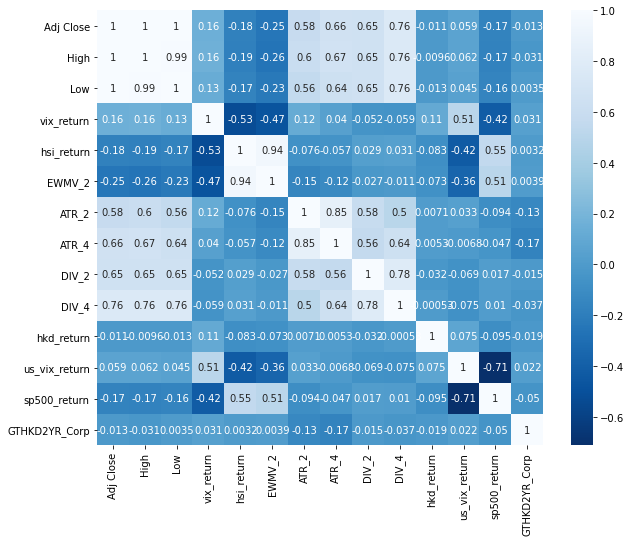

In [33]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(),annot=True,cmap='Blues_r')

In [34]:
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X),index = X.index,columns=X.columns)
scaled_X

,Adj Close,High,Low,vix_return,hsi_return,EWMV_2,ATR_2,ATR_4,DIV_2,DIV_4,hkd_return,us_vix_return,sp500_return,GTHKD2YR_Corp
2001-07-20,0.048801,0.008581,0.090030,0.196701,-0.861352,-1.164028,-0.436719,-0.855887,-0.379230,-0.376360,-0.000719,0.387654,-0.201961,2.070104
2001-07-27,0.145423,0.104253,0.187730,0.345203,-0.342859,-0.710197,-0.799058,-0.834578,-0.579078,-0.395183,-0.000719,-0.107433,-0.209222,1.995039
2001-08-03,-0.080028,-0.118980,-0.040235,-0.834667,0.232145,-0.018080,-0.859327,-0.763340,-0.246014,-0.241819,-0.056027,-0.707370,0.238722,2.014793
2001-08-10,0.143275,0.102127,0.185559,0.822619,-1.437637,-1.357945,-0.315238,-0.656001,0.594488,-0.095879,0.036168,0.229278,-0.846797,1.927085
2001-08-17,0.311826,0.269020,0.355989,0.574156,-0.042017,-0.491869,-0.558711,-0.835386,0.526474,-0.131314,0.036166,1.042351,-1.000606,1.862292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,1.838448,1.917756,1.378575,1.113895,-2.969072,-3.270020,1.069235,1.241131,0.097217,0.773091,0.066167,-0.998958,1.505623,2.313473
2022-11-04,1.628028,1.735981,1.488216,-0.461109,2.843555,1.584896,2.813865,2.092369,1.155794,0.996546,0.041436,-0.334711,-1.402386,2.471505
2022-11-11,1.582937,1.617986,1.253737,-0.103662,2.361243,2.749546,2.473356,2.094274,1.093692,1.441203,-0.400267,-0.605491,2.246539,2.319004
2022-11-18,1.318838,1.488298,1.373148,-0.620246,1.277082,2.118018,1.604088,2.611248,-0.317705,1.704629,-1.737950,0.184719,-0.319925,2.355351


### Train validation test

In [35]:
# train and test
split_date_1 = dt.datetime(2018,6,29)
split_date_2 = dt.datetime(2018,7,6)
X_train, X_test = scaled_X.loc[:split_date_1,:], scaled_X.loc[split_date_2:,:]
Y_train, Y_test = Y[:split_date_1], Y[split_date_2:]
# train and validation
split_date_1 = dt.datetime(2014,4,4)
split_date_2 = dt.datetime(2014,4,11)
X_train_v, X_validation = X_train.loc[:split_date_1,:], X_train.loc[split_date_2:,:]
Y_train_v, Y_validation = Y_train.loc[:split_date_1], Y_train.loc[split_date_2:]

In [36]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [108]:
names = []
is_accuracy = []
os_accuracy = []
is_gmeanf1 = []
os_gmeanf1 = []

### Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier 

In [24]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = { 'min_samples_split': [2, 3, 4], 'max_depth': np.arange(3,15),
#                  'min_samples_leaf': [1,2,3,4]}
# model = DecisionTreeClassifier()
# optimized_DT = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_DT.fit(np.array(X_train_v), np.array(Y_train_v))
# model = optimized_DT.best_estimator_
# print('Best parameters：{0}'.format(optimized_DT.best_params_))
# print('Score:{0}'.format(optimized_DT.best_score_))

Best parameters：{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Score:0.5723981900452488


In [39]:
DT = DecisionTreeClassifier(max_depth=4,min_samples_leaf=1,min_samples_split=2).fit(X_train_v, Y_train_v)

In [40]:
y_pred_DT_is = DT.predict(X_train_v)
y_pred_DT_os = DT.predict(X_validation)
accuracy_DT_is = metrics.accuracy_score(Y_train_v, y_pred_DT_is)
accuracy_DT_os = metrics.accuracy_score(Y_validation, y_pred_DT_os)
print("DT accuarcy in sample:",accuracy_DT_is)
print("DT accuarcy out sample:",accuracy_DT_os)

DT accuarcy in sample: 0.6385542168674698
DT accuarcy out sample: 0.5610859728506787


In [41]:
g_mean_f1_DT_is = g_mean_f1(Y_train_v, y_pred_DT_is)
g_mean_f1_DT_os = g_mean_f1(Y_validation, y_pred_DT_os)
print("DT gmean f1 in sample:",g_mean_f1_DT_is)
print("DT gmean f1 out sample:",g_mean_f1_DT_os)

DT gmean f1 in sample: 0.5823263898344692
DT gmean f1 out sample: 0.5174982104010569


In [109]:
names.append('DT')
is_accuracy.append(accuracy_DT_is)
os_accuracy.append(accuracy_DT_os)
is_gmeanf1.append(g_mean_f1_DT_is)
os_gmeanf1.append(g_mean_f1_DT_os)

### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [146]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = { 'n_estimators':[25,50,100,200],'min_samples_split': [2, 3, 4], 'max_depth': np.arange(3,13),
#                  'min_samples_leaf': [1,2,3],'max_features':["auto", "sqrt", "log2"]}
# model = RandomForestClassifier()
# optimized_RF = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_RF.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_RF.best_params_))
# print('Score:{0}'.format(optimized_RF.best_score_))

Best parameters：{'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 25}
Score:0.5859728506787331


In [102]:
RF= RandomForestClassifier(n_estimators=25,  max_features="auto", max_depth=6,
                           min_samples_leaf=3, min_samples_split=2).fit(X_train_v,Y_train_v)

In [103]:
y_pred_RF_is = RF.predict(X_train_v)
y_pred_RF_os = RF.predict(X_validation)
accuracy_RF_is = metrics.accuracy_score(Y_train_v, y_pred_RF_is)
accuracy_RF_os = metrics.accuracy_score(Y_validation, y_pred_RF_os)
print("RF accuarcy in sample:",accuracy_RF_is)
print("RF accuarcy out sample:",accuracy_RF_os)

RF accuarcy in sample: 0.8132530120481928
RF accuarcy out sample: 0.5701357466063348


In [104]:
g_mean_f1_RF_is = g_mean_f1(Y_train_v, y_pred_RF_is)
g_mean_f1_RF_os = g_mean_f1(Y_validation, y_pred_RF_os)
print("RF gmean f1 in sample:",g_mean_f1_RF_is)
print("RF gmean f1 out sample:",g_mean_f1_RF_os)

RF gmean f1 in sample: 0.8061932020251701
RF gmean f1 out sample: 0.5699417420664312


In [110]:
names.append('RF')
is_accuracy.append(accuracy_RF_is)
os_accuracy.append(accuracy_RF_os)
is_gmeanf1.append(g_mean_f1_RF_is)
os_gmeanf1.append(g_mean_f1_RF_os)

### Extremely Randomized Trees

In [48]:
from sklearn.ensemble import ExtraTreesClassifier

In [36]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators':[25,50,100,200],'min_samples_split': [2, 3, 4], 'max_depth': np.arange(3,13),
#                  'min_samples_leaf': [1,2,3],'max_features':["auto", "sqrt", "log2"]}
# model = ExtraTreesClassifier()
# optimized_ETC = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_ETC.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_ETC.best_params_))
# print('Score:{0}'.format(optimized_ETC.best_score_))

Best parameters：{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
Score:0.5995475113122173


In [105]:
ETC= ExtraTreesClassifier(n_estimators=50, 
                          max_depth=7,
                          max_features='sqrt',
                          min_samples_leaf=3,
                          min_samples_split=2).fit(X_train_v,Y_train_v.values.ravel())

In [106]:
y_pred_ETC_is = ETC.predict(X_train_v)
y_pred_ETC_os = ETC.predict(X_validation)
accuracy_ETC_is = metrics.accuracy_score(Y_train_v, y_pred_ETC_is)
accuracy_ETC_os = metrics.accuracy_score(Y_validation, y_pred_ETC_os)
print("ETC accuarcy in sample:",accuracy_ETC_is)
print("ETC accuarcy out sample:",accuracy_ETC_os)

ETC accuarcy in sample: 0.75
ETC accuarcy out sample: 0.5656108597285068


In [107]:
g_mean_f1_ETC_is = g_mean_f1(Y_train_v, y_pred_ETC_is)
g_mean_f1_ETC_os = g_mean_f1(Y_validation, y_pred_ETC_os)
print("ETC gmean f1 in sample:",g_mean_f1_ETC_is)
print("ETC gmean f1 out sample:",g_mean_f1_ETC_os)

ETC gmean f1 in sample: 0.7358888346109168
ETC gmean f1 out sample: 0.5577634353164503


In [111]:
names.append('ETC')
is_accuracy.append(accuracy_ETC_is)
os_accuracy.append(accuracy_ETC_os)
is_gmeanf1.append(g_mean_f1_ETC_is)
os_gmeanf1.append(g_mean_f1_ETC_os)

### AdaBoost

In [53]:
from sklearn.ensemble import AdaBoostClassifier

In [42]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators':[25,50,100,200],'learning_rate': np.linspace(0.1,1,10),'algorithm':['SAMME','SAMME.R'],
#             'base_estimator__min_samples_split': [2, 3, 4], 'base_estimator__max_depth': np.arange(1,5),
#                  'base_estimator__min_samples_leaf': [1,2,3]}
# base_estimator=DecisionTreeClassifier()
# model = AdaBoostClassifier(base_estimator=base_estimator)
# optimized_ADB = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_ADB.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_ADB.best_params_))
# print('Score:{0}'.format(optimized_ADB.best_score_))

Best parameters：{'algorithm': 'SAMME.R', 'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 2, 'base_estimator__min_samples_split': 3, 'learning_rate': 0.1, 'n_estimators': 100}
Score:0.5859728506787331


In [54]:
base_estimator=DecisionTreeClassifier(max_depth=3,min_samples_leaf=2,min_samples_split=3)
ADB = AdaBoostClassifier(n_estimators=100, algorithm= 'SAMME.R',learning_rate=0.1,base_estimator=base_estimator).fit(X_train_v,Y_train_v)

In [55]:
y_pred_ADB_is = ADB.predict(X_train_v)
y_pred_ADB_os = ADB.predict(X_validation)
accuracy_ADB_is = metrics.accuracy_score(Y_train_v, y_pred_ADB_is)
accuracy_ADB_os = metrics.accuracy_score(Y_validation, y_pred_ADB_os)
print("ADB accuarcy in sample:",accuracy_ADB_is)
print("ADB accuarcy out sample:",accuracy_ADB_os)

ADB accuarcy in sample: 0.9819277108433735
ADB accuarcy out sample: 0.5520361990950227


In [112]:
g_mean_f1_ADB_is = g_mean_f1(Y_train_v, y_pred_ADB_is)
g_mean_f1_ADB_os = g_mean_f1(Y_validation, y_pred_ADB_os)
print("ADB gmean f1 in sample:",g_mean_f1_ADB_is)
print("ADB gmean f1 out sample:",g_mean_f1_ADB_os)

ADB gmean f1 in sample: 0.9818397519501355
ADB gmean f1 out sample: 0.550170928529125


In [113]:
names.append('ADB')
is_accuracy.append(accuracy_ADB_is)
os_accuracy.append(accuracy_ADB_os)
is_gmeanf1.append(g_mean_f1_ADB_is)
os_gmeanf1.append(g_mean_f1_ADB_os)

### XGBoost

In [58]:
from xgboost import XGBClassifier
Y_xgbc_train_v = Y_train_v.apply(lambda x:np.where(x==-1,0,x))
Y_xgbc_validation = Y_validation.apply(lambda x:np.where(x==-1,0,x))

In [149]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators': [25,50,100,200], 'learning_rate': [0.01, 0.1, 0.5, 1], 'max_depth': np.arange(3,13),
#                  'min_child_weight': [4, 5, 6], 'gamma': [1, 3], 'reg_alpha': [0.1, 0.3,0.5],"reg_lambda": [0.3,0.5,0.7,0.9]}
# other_params = {'learning_rate': 0.1, 'n_estimators': 90, 'max_depth': 7, 'min_child_weight': 4,
#                      'gamma': 1, 'reg_alpha': 0.1, "reg_lambda": 0.9}
# model = XGBClassifier()
# optimized_XGBC = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_XGBC.fit(np.array(X_train_v), np.array(Y_xgbc_train_v))
# print('Best parameters：{0}'.format(optimized_XGBC.best_params_))
# print('Score:{0}'.format(optimized_XGBC.best_score_))

Best parameters：{'gamma': 1, 'learning_rate': 1, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 50, 'reg_alpha': 0.3, 'reg_lambda': 0.3}
Score:0.5972850678733032


In [62]:
XGBC = XGBClassifier(learning_rate= 1,
                     n_estimators=50,
                     max_depth= 5, 
                     min_child_weight=6, 
                     gamma=1, 
                     reg_alpha= 0.3,
                     reg_lambda=0.3).fit(np.array(X_train_v), np.array(Y_xgbc_train_v))

In [63]:
y_pred_XGBC_is = XGBC.predict(X_train_v)
y_pred_XGBC_is = np.where(y_pred_XGBC_is==0,-1,y_pred_XGBC_is)
y_pred_XGBC_os = XGBC.predict(X_validation)
y_pred_XGBC_os = np.where(y_pred_XGBC_os==0,-1,y_pred_XGBC_os)
accuracy_XGBC_is = metrics.accuracy_score(Y_train_v, y_pred_XGBC_is)
accuracy_XGBC_os = metrics.accuracy_score(Y_validation, y_pred_XGBC_os)
print("XGBC accuarcy in sample:",accuracy_XGBC_is)
print("XGBC accuarcy out sample:",accuracy_XGBC_os)

XGBC accuarcy in sample: 0.9849397590361446
XGBC accuarcy out sample: 0.5294117647058824


In [64]:
g_mean_f1_XGBC_is = g_mean_f1(Y_train_v, y_pred_XGBC_is)
g_mean_f1_XGBC_os = g_mean_f1(Y_validation, y_pred_XGBC_os)
print("XGBC gmean f1 in sample:",g_mean_f1_XGBC_is)
print("XGBC gmean f1 out sample:",g_mean_f1_XGBC_os)

XGBC gmean f1 in sample: 0.9848844858490768
XGBC gmean f1 out sample: 0.5277208795994232


In [114]:
names.append('XGBC')
is_accuracy.append(accuracy_XGBC_is)
os_accuracy.append(accuracy_XGBC_os)
is_gmeanf1.append(g_mean_f1_XGBC_is)
os_gmeanf1.append(g_mean_f1_XGBC_os)

### Model Comparison

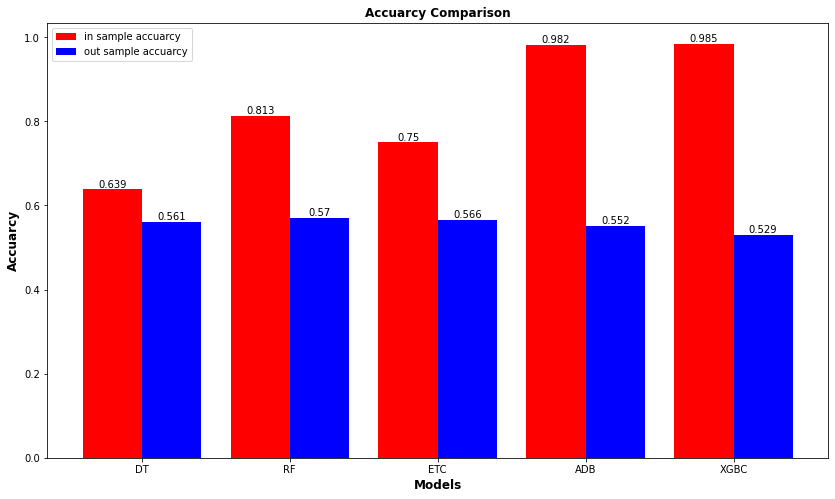

In [115]:
plt.figure(figsize = (14,8))

accuracy_df =pd.DataFrame({'name':names,'accuracy_is':is_accuracy,'accuracy_os':os_accuracy}).set_index('name')
x_axis = np.arange(len(accuracy_df))

barplot_is_accuarcy = plt.bar(x_axis-0.2, accuracy_df['accuracy_is'], 0.4, label='in sample accuarcy',color='red')
barplot_os_accuarcy = plt.bar(x_axis+0.2, accuracy_df['accuracy_os'], 0.4, label='out sample accuarcy',color='blue')

plt.bar_label(barplot_is_accuarcy, labels = np.round(accuracy_df['accuracy_is'],3))
plt.bar_label(barplot_os_accuarcy, labels = np.round(accuracy_df['accuracy_os'],3))

plt.xticks(x_axis, accuracy_df.index)
plt.xlabel("Models", fontsize = 12, fontweight = "bold") 
plt.ylabel("Accuarcy",fontsize = 12, fontweight = "bold")
plt.title("Accuarcy Comparison", fontsize = 12, fontweight = "bold")
plt.legend()
plt.show()

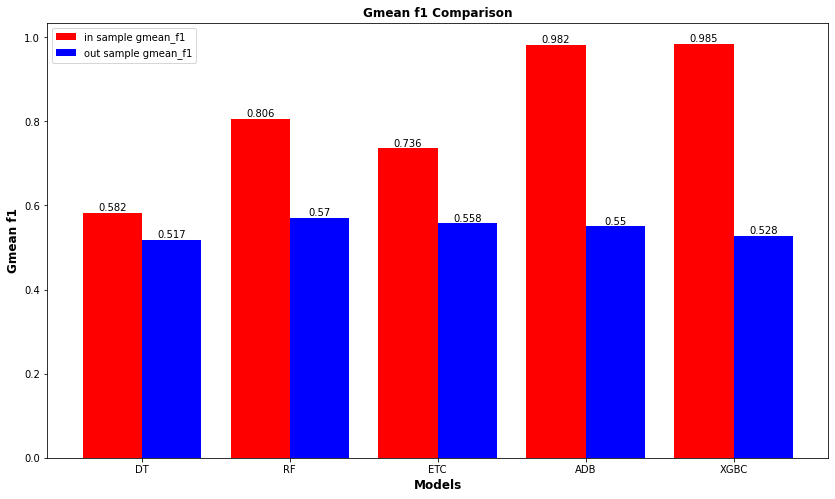

In [116]:
plt.figure(figsize = (14,8))

f1_df =pd.DataFrame({'name':names,'f1_is':is_gmeanf1,'f1_os':os_gmeanf1}).set_index('name')
x_axis = np.arange(len(f1_df))

barplot_is_f1 = plt.bar(x_axis-0.2, f1_df['f1_is'], 0.4, label='in sample gmean_f1',color='red')
barplot_os_f1 = plt.bar(x_axis+0.2, f1_df['f1_os'], 0.4, label='out sample gmean_f1',color='blue')

plt.bar_label(barplot_is_f1, labels = np.round(f1_df['f1_is'],3))
plt.bar_label(barplot_os_f1, labels = np.round(f1_df['f1_os'],3))

plt.xticks(x_axis, f1_df.index)
plt.xlabel("Models", fontsize = 12, fontweight = "bold") 
plt.ylabel("Gmean f1",fontsize = 12, fontweight = "bold")
plt.title("Gmean f1 Comparison", fontsize = 12, fontweight = "bold")
plt.legend()
plt.show()

### Select Random Forest model

In [141]:
RF= RandomForestClassifier(n_estimators=25,  max_features="auto", max_depth=6,
                           min_samples_leaf=3, min_samples_split=2).fit(X_train,Y_train)

In [142]:
y_pred_RF_is = RF.predict(X_train)
y_pred_RF_os = RF.predict(X_test)
accuracy_RF_is = metrics.accuracy_score(Y_train, y_pred_RF_is)
accuracy_RF_os = metrics.accuracy_score(Y_test.dropna(), y_pred_RF_os[:-1])
print("RF accuarcy in sample:",accuracy_RF_is)
print("RF accuarcy out sample:",accuracy_RF_os)

RF accuarcy in sample: 0.7988700564971751
RF accuarcy out sample: 0.5851528384279476


In [143]:
g_mean_f1_RF_is = g_mean_f1(Y_train, y_pred_RF_is)
g_mean_f1_RF_os = g_mean_f1(Y_test.dropna(), y_pred_RF_os[:-1])
print("RF gmean f1 in sample:",g_mean_f1_RF_is)
print("RF gmean f1 out sample:",g_mean_f1_RF_os)

RF gmean f1 in sample: 0.7929503471164496
RF gmean f1 out sample: 0.5354338612706726


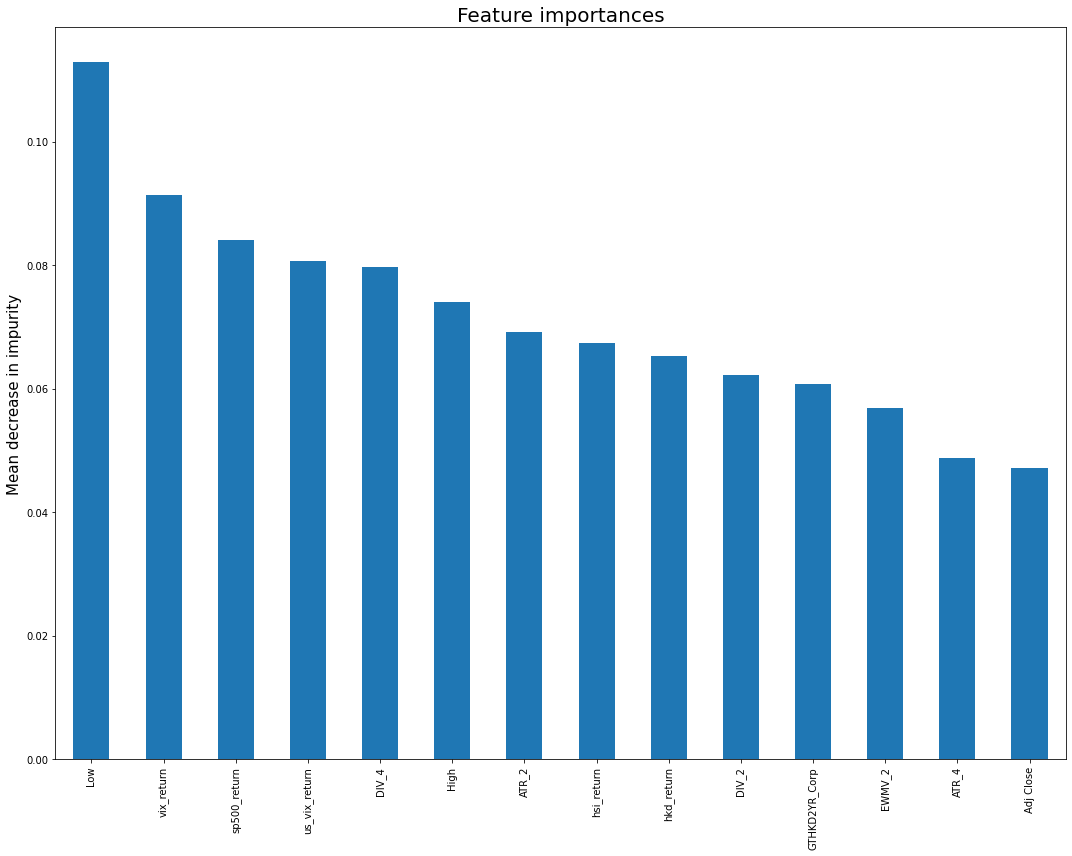

In [144]:
forest_importances = pd.Series(RF.feature_importances_,index=X_train.columns)
forest_importances.sort_values(ascending=False,inplace=True)

fig,ax=plt.subplots(figsize=(15,12))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances",fontsize=20) 
ax.set_ylabel("Mean decrease in impurity",fontsize=15)
fig.tight_layout()

### predict result

In [145]:
result = pd.DataFrame({'actual':Y_test,'pred':RF.predict(X_test)})
result

,actual,pred
2018-07-06,-1.0,-1.0
2018-07-13,-1.0,-1.0
2018-07-20,-1.0,-1.0
2018-07-27,1.0,-1.0
2018-08-03,-1.0,-1.0
...,...,...
2022-10-28,-1.0,-1.0
2022-11-04,-1.0,-1.0
2022-11-11,-1.0,-1.0
2022-11-18,-1.0,-1.0


In [146]:
result.to_csv('hk_result.csv')

In [147]:
len(result[result.actual == 1])/ len(result)

0.4608695652173913

In [148]:
len(result[result.actual == -1])/ len(result)

0.5347826086956522